## learning how to generate a graphminor for folded RNA

#### initialize...

In [8]:
%load_ext autoreload
%autoreload 2
from eden.util import configure_logging
import logging
DEBUG=False
NJOBS=4
if DEBUG:
    NJOBS=1
configure_logging(logging.getLogger(),verbosity=1+DEBUG)
%matplotlib inline
!pwd
!date

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/ikea/GraphLearn/GraphLearn_examples/Abstract
Thu Apr 14 16:54:02 KST 2016


## Create a function that is able to deliver a graph iterator

In [9]:
# get data
from itertools import islice
from eden.converter.fasta import fasta_to_sequence
from eden.converter.rna.rnafold import rnafold_to_eden
from eden.converter.fasta import fasta_to_sequence
import itertools
from eden.graph import Vectorizer

def rfam_uri(family_id):
    return 'http://rfam.xfam.org/family/%s/alignment?acc=%s&format=fastau&download=0'%(family_id,family_id)
def rfam_uri(family_id):
    return '%s.fa'%(family_id)

def get_sequences(size=9999,withoutnames=False):
    sequences = itertools.islice( fasta_to_sequence("../toolsdata/RF00005.fa"), size)
    if withoutnames:
        return [ b for (a,b) in sequences ]
    return sequences



## taking a closer look at the preprocessor

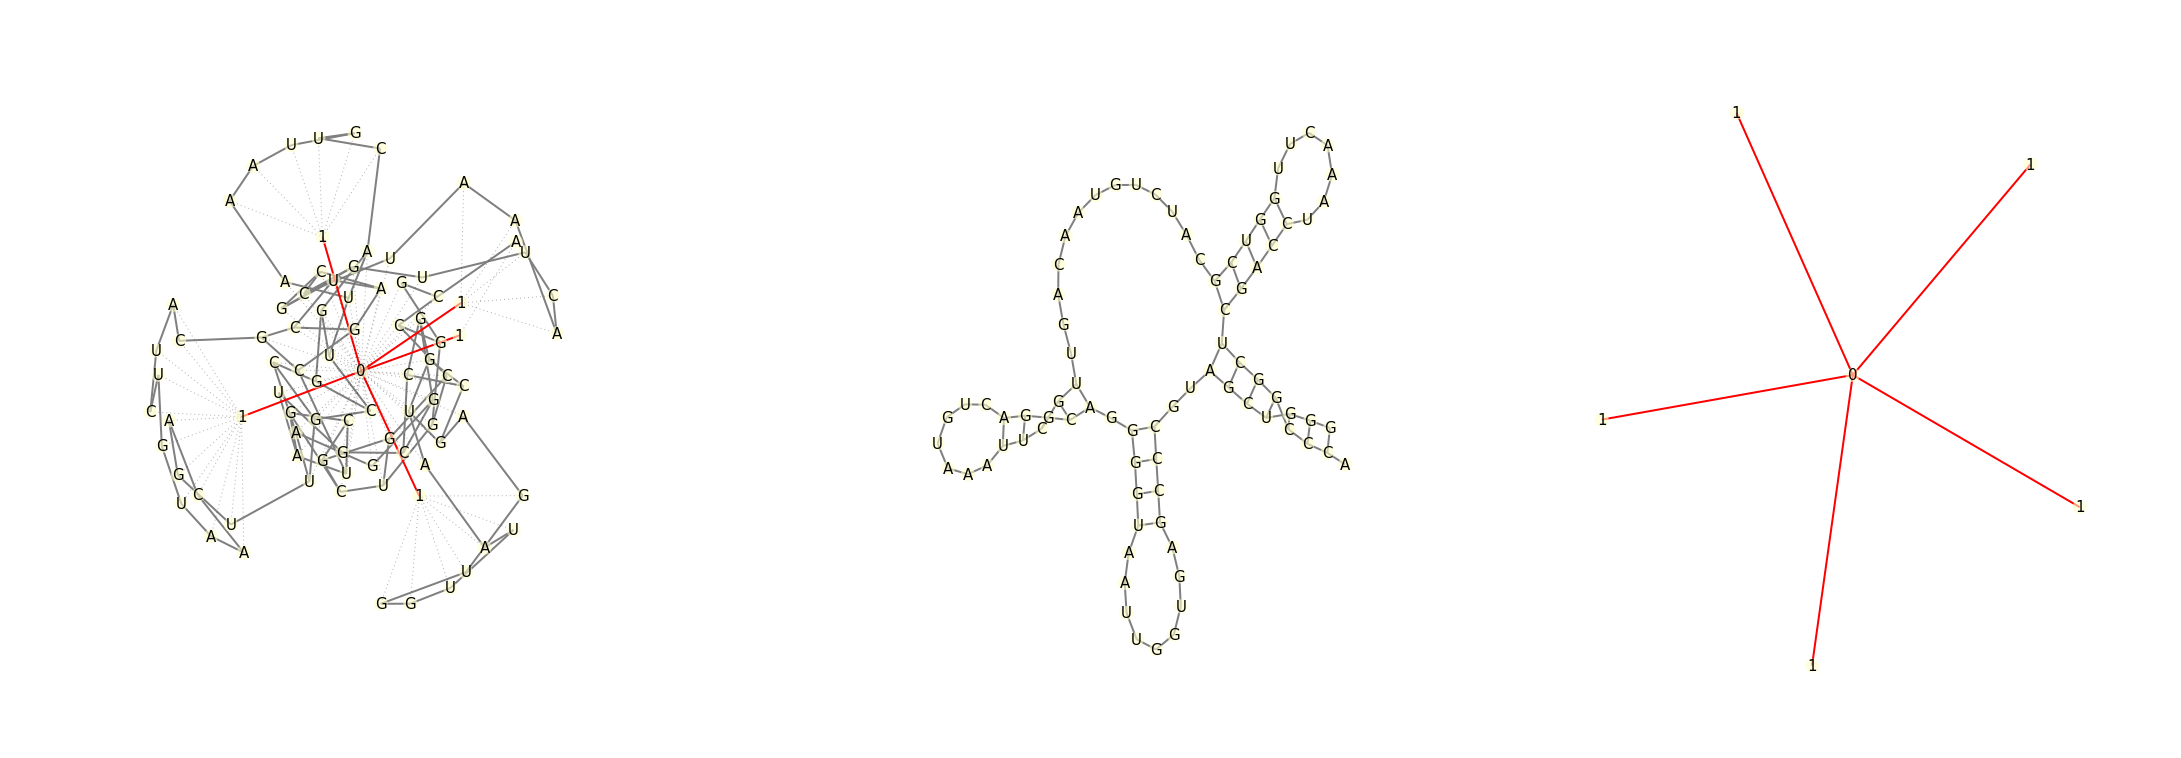

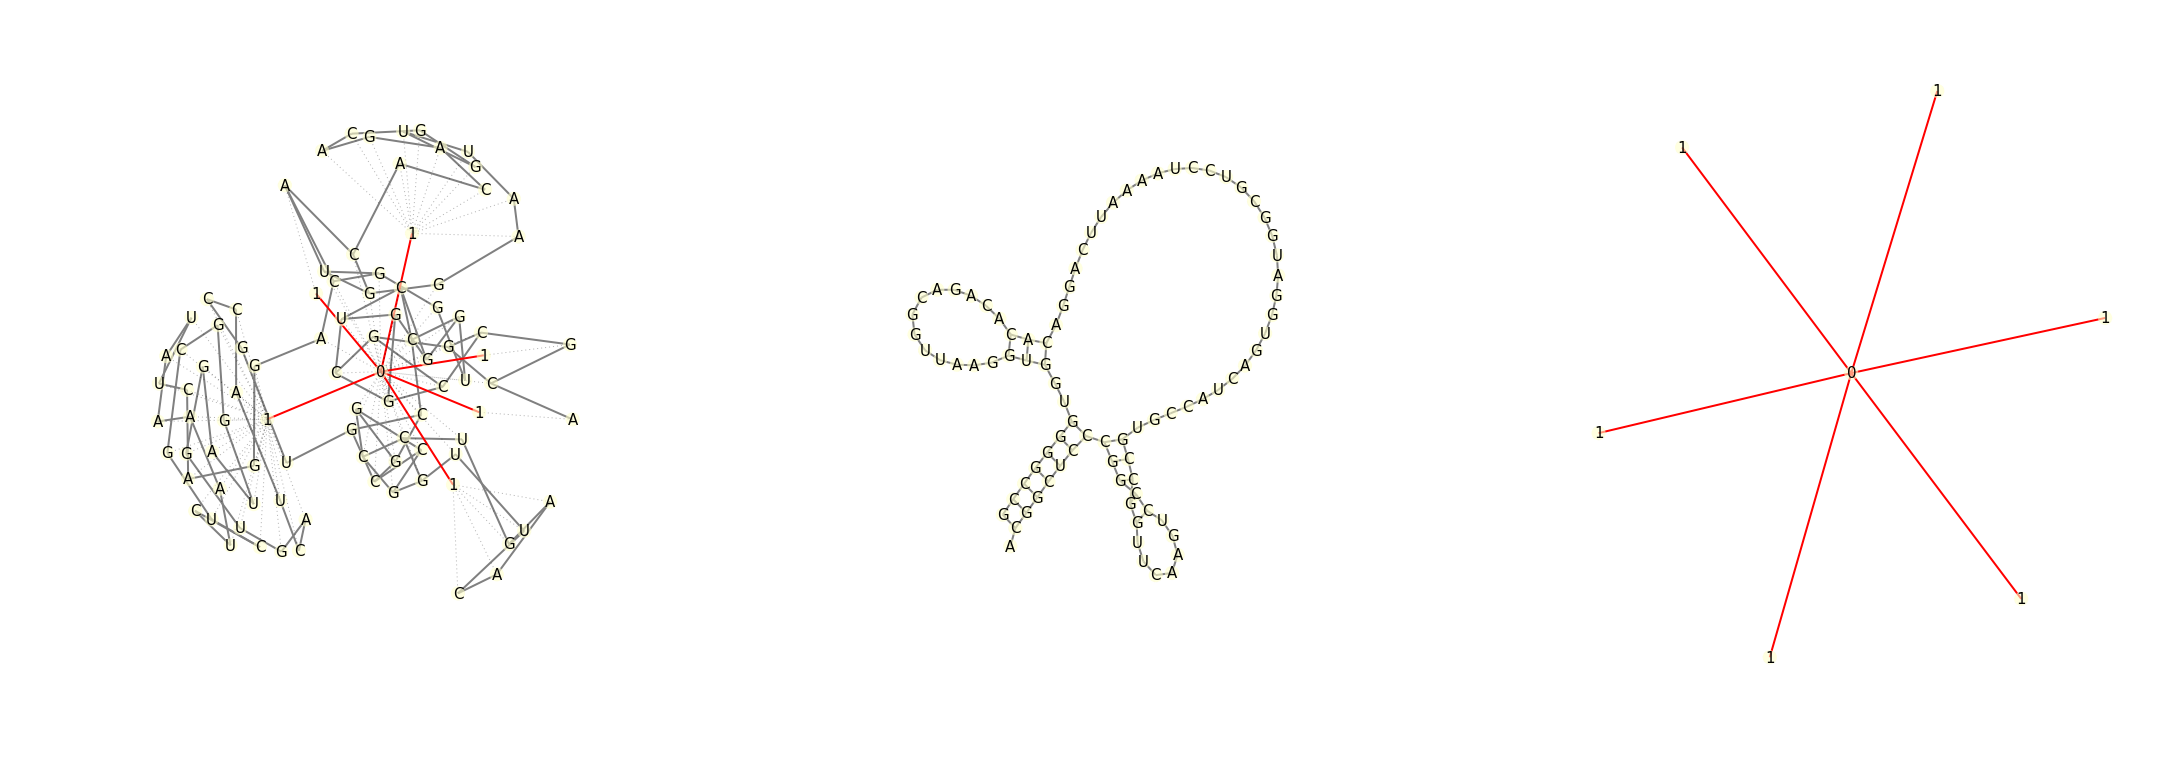

In [10]:
from graphlearn.utils import draw
import graphlearn.abstract_graphs.rna.rnatransform as learned
from eden.graph import Vectorizer
from sklearn.cluster import KMeans

import graphlearn.abstract_graphs.rna.rnadecomposer as decompose
v=Vectorizer()
make_decomposer = lambda x,y: decompose.RnaDecomposer(x,y,
                       include_base=False,
                       base_thickness_list=[2])


if True:
    # if we are not interested in what the pp does we can skip this because it is slow
    # it shows how the created abstractions look like.
    pp=learned.GraphTransformerRNA(shape_cluster=KMeans(n_clusters=2),structure_mod=False)
    pp.set_param(v)
    gm=[make_decomposer(v,x) for x in pp.fit_transform(get_sequences(40))]
    for i in range(2):
        draw.graphlearn([gm[i+5].pre_vectorizer_graph(),gm[i+5].base_graph(),gm[i+5].abstract_graph()],size=13,contract=True, abstract_color='red')
    
    


## fitting sampler

In [11]:
%%time

import graphlearn.abstract_graphs.rna.rnatransform as learned
import graphlearn.abstract_graphs.rna.infernal as infernal
import graphlearn.abstract_graphs.rna.rnafeasibility as feas
from graphlearn import feasibility
import graphlearn.estimate as estimate

#get some graphs
graphs = get_sequences(40)
#estimator wrapper... (default has nu=0.5)
estimator=estimate.OneClassEstimator( nu=.33, cv=2, n_jobs=NJOBS)
#feasibility checker can decide if a graph is a valid rna
feas=feasibility.FeasibilityChecker(checklist=[feasibility.default_check,feas.is_rna])
#preprocessor  for rna..  it will take care of consensus folding etc
pp=learned.GraphTransformerRNA(shape_cluster=KMeans(n_clusters=2) ,structure_mod=False)

# create a sampler and fit
sampler=infernal.AbstractSampler(radius_list=[0,1],
                            thickness_list=[1], 
                            min_cip_count=1, 
                            min_interface_count=2,
                            feasibility_checker=feas, 
                            graphtransformer=pp,
                            decomposergen=make_decomposer,
                            estimator=estimator)
sampler.fit(graphs,grammar_n_jobs=NJOBS,grammar_batch_size=1)

CPU times: user 13.9 s, sys: 3.93 s, total: 17.9 s
Wall time: 43.6 s


interface id: 629305 [8 options]


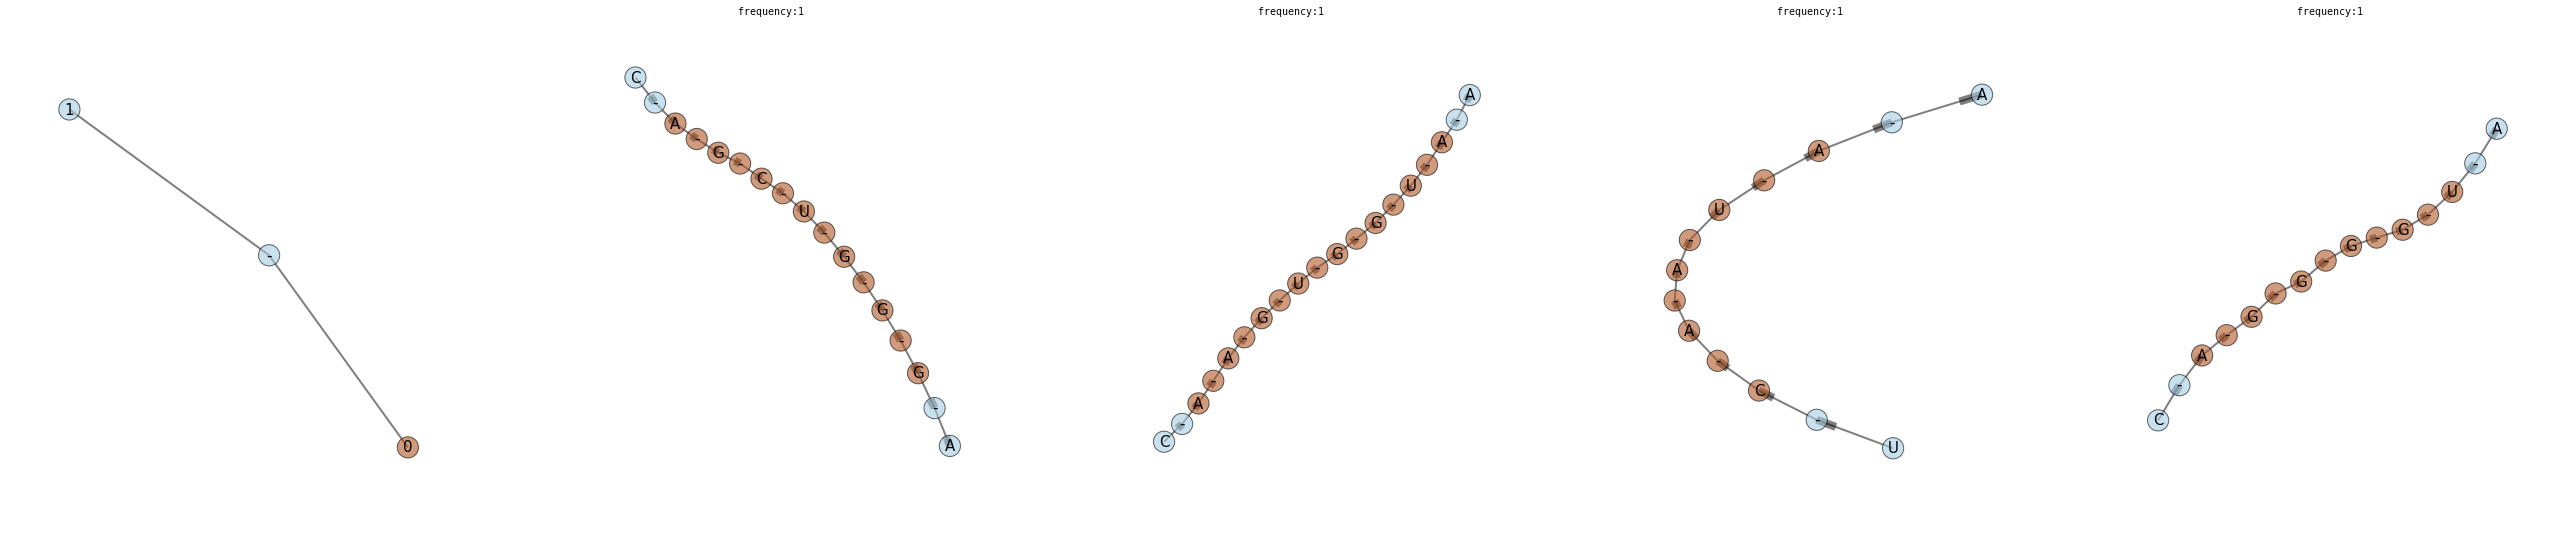

interface id: 680311 [7 options]


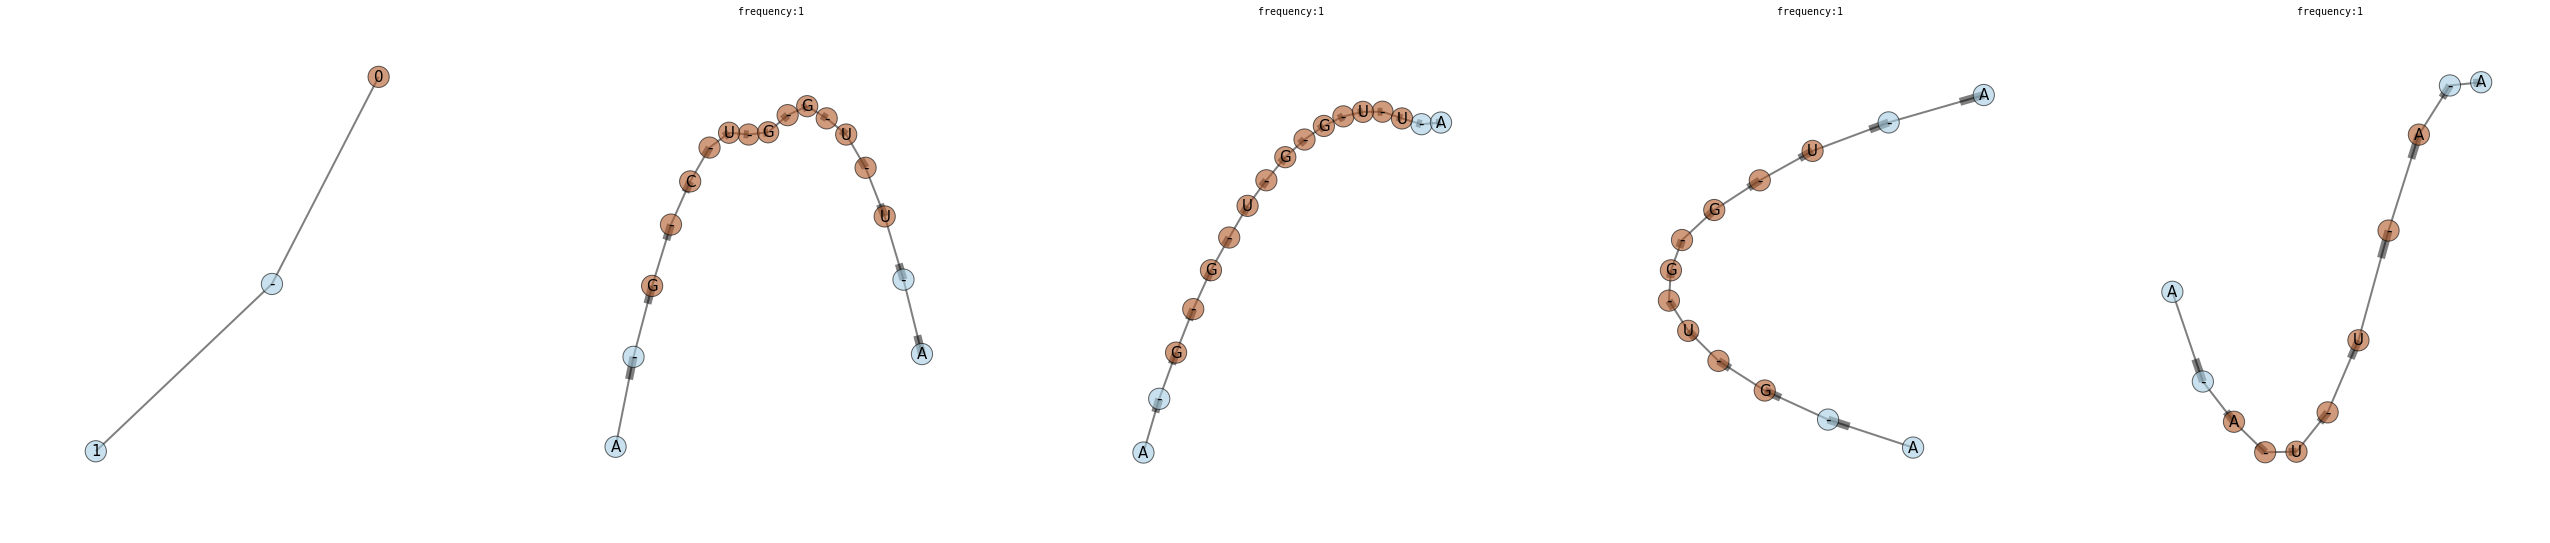

interface id: 491983 [7 options]


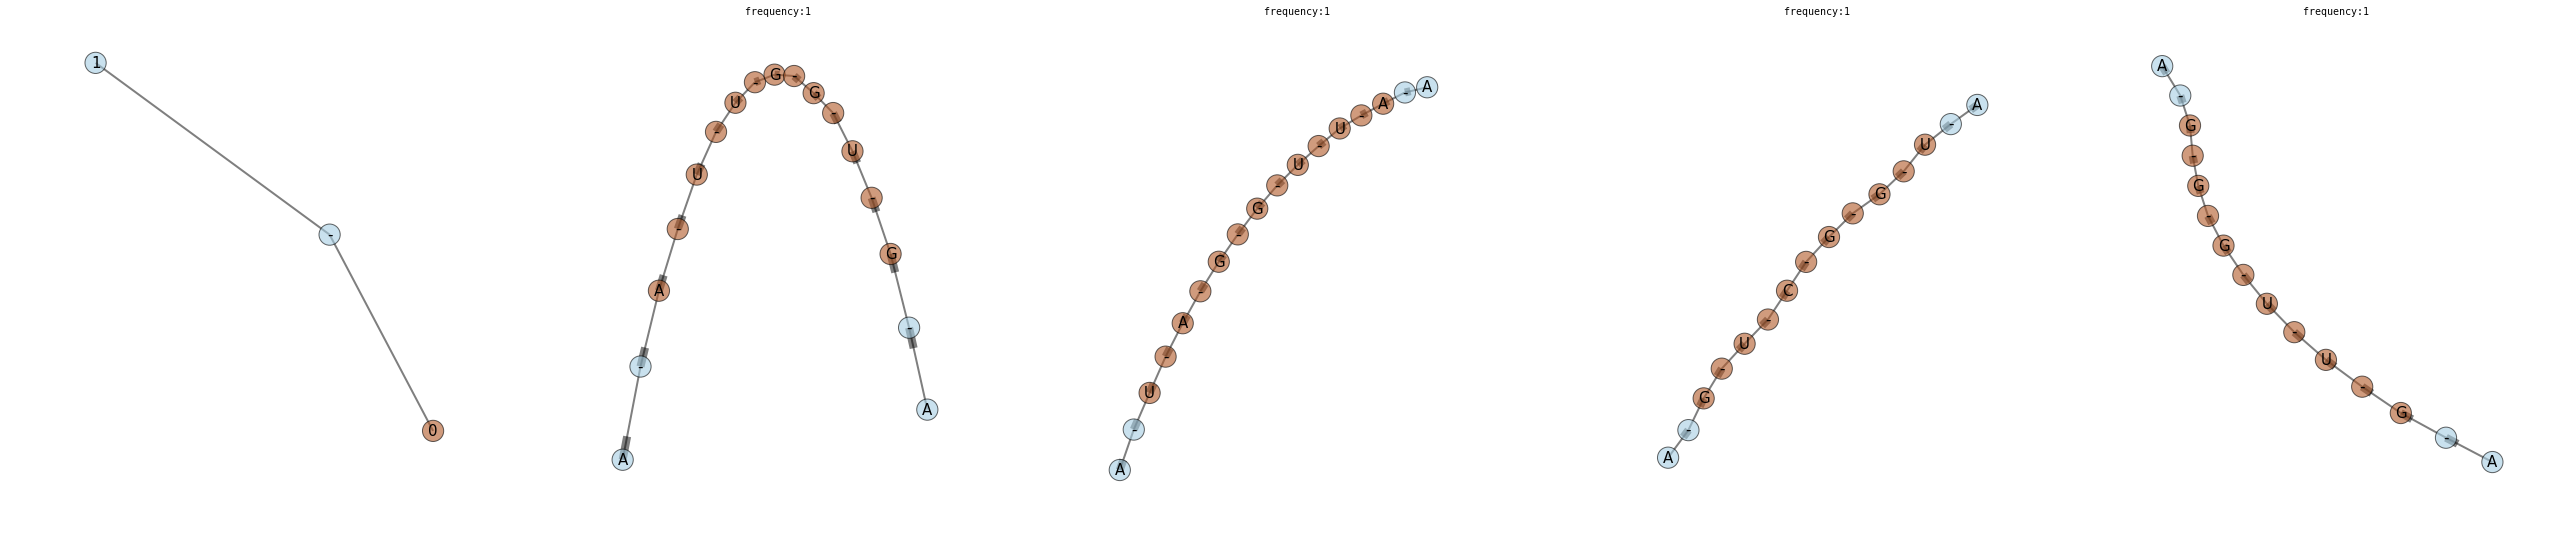

interface id: 214949 [7 options]


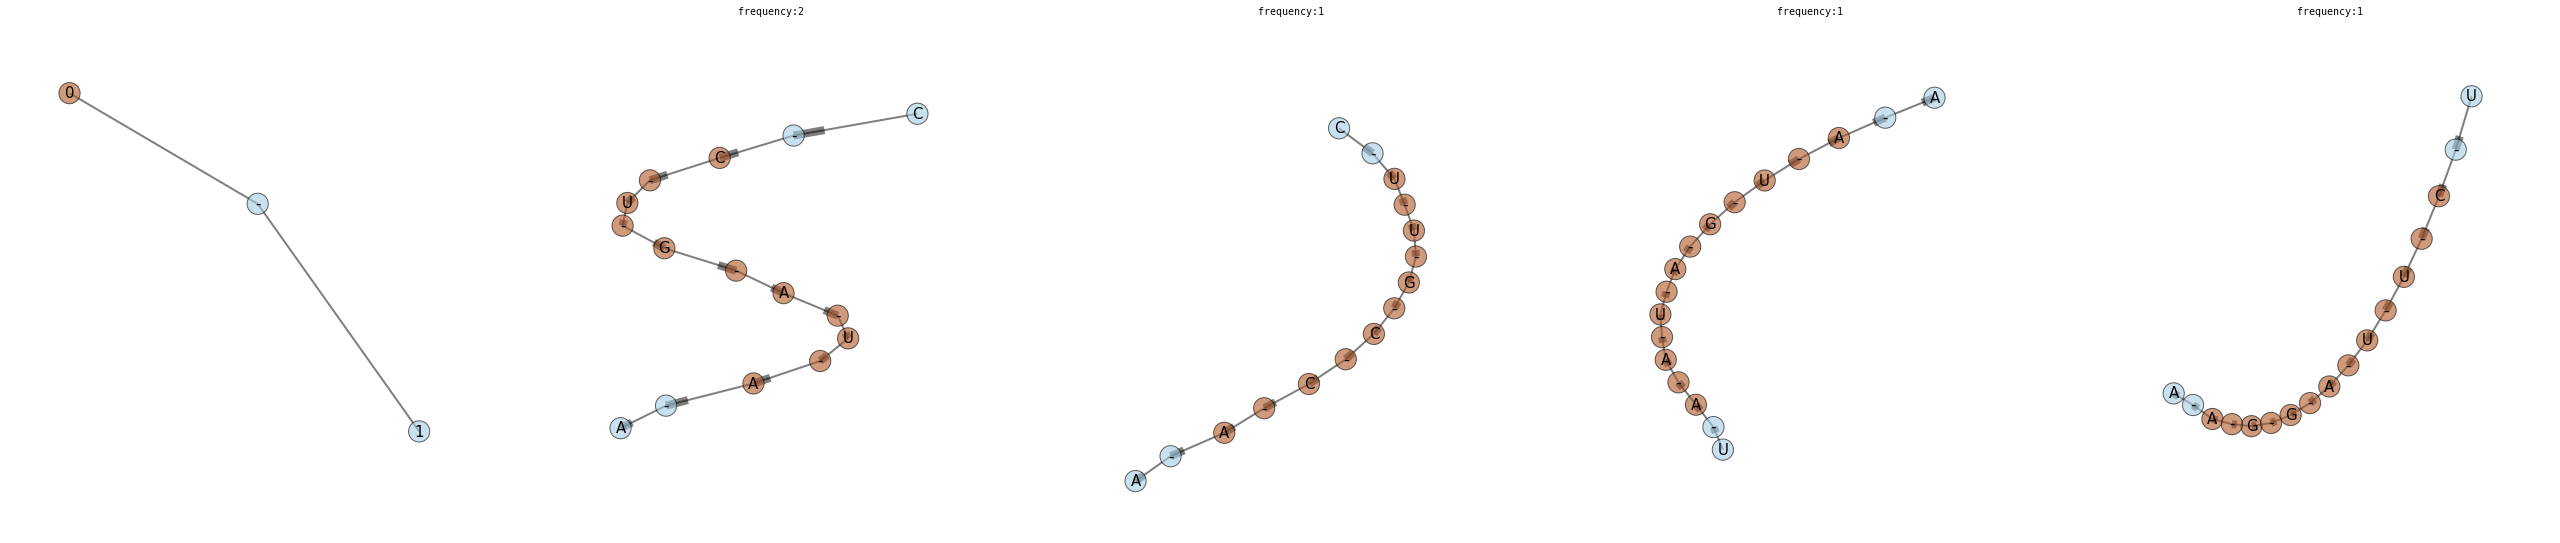

interface id: 957825 [6 options]


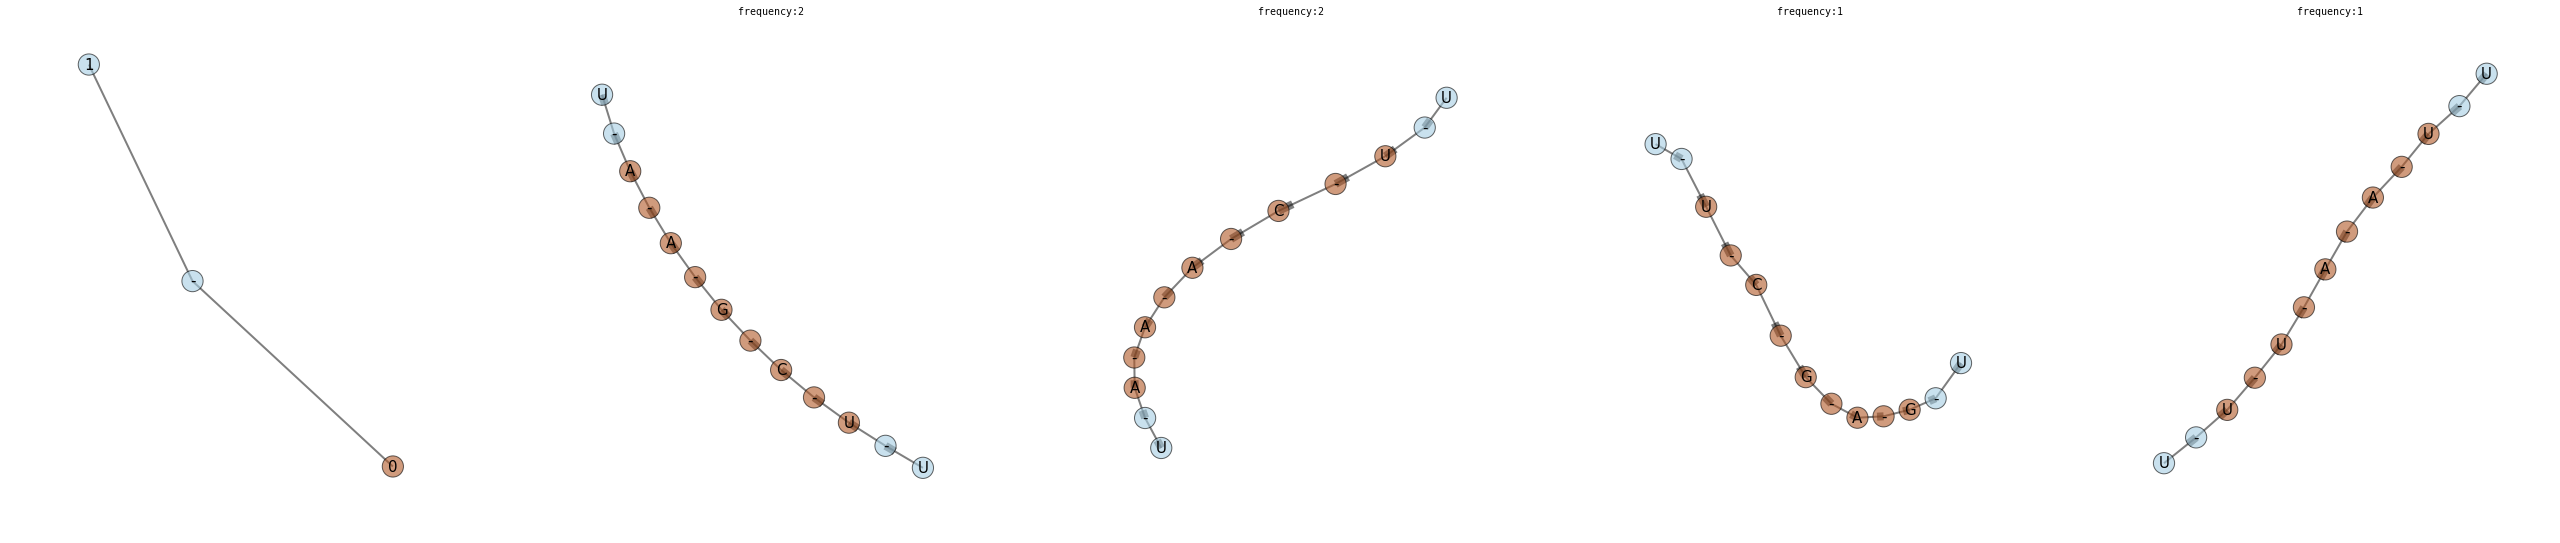

In [12]:
#draw production rules
from graphlearn.utils import draw
draw.draw_grammar(sampler.lsgg.productions,n_productions=5,n_graphs_per_production=5,
                     n_graphs_per_line=5, size=9, contract=False,
                     colormap='Paired', invert_colormap=False,node_border=1,
                     vertex_alpha=0.6, edge_alpha=0.5, node_size=450, abstract_interface=True)


## sample and show samples

Graph id: 66


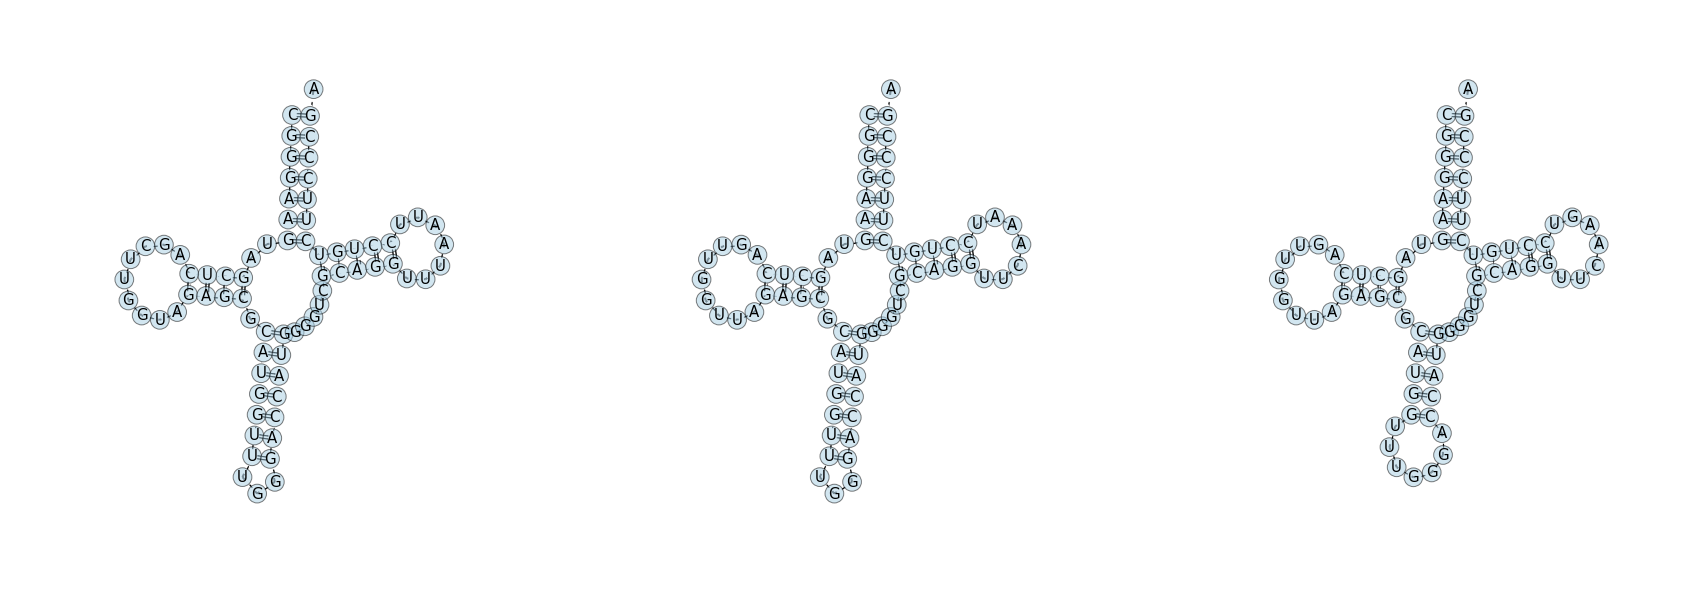

Graph id: 67


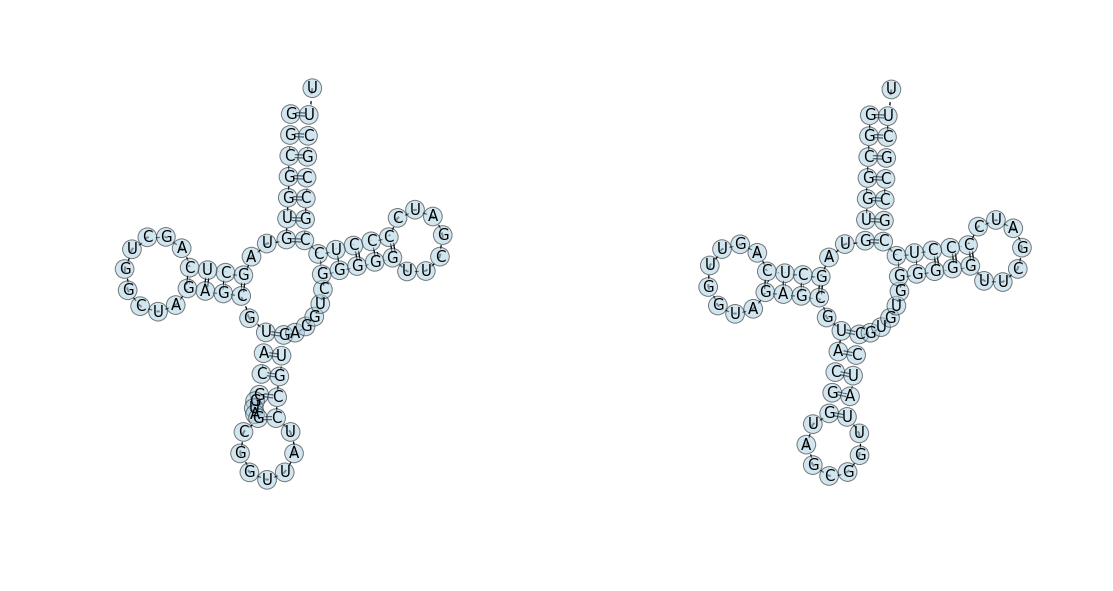

Graph id: 68


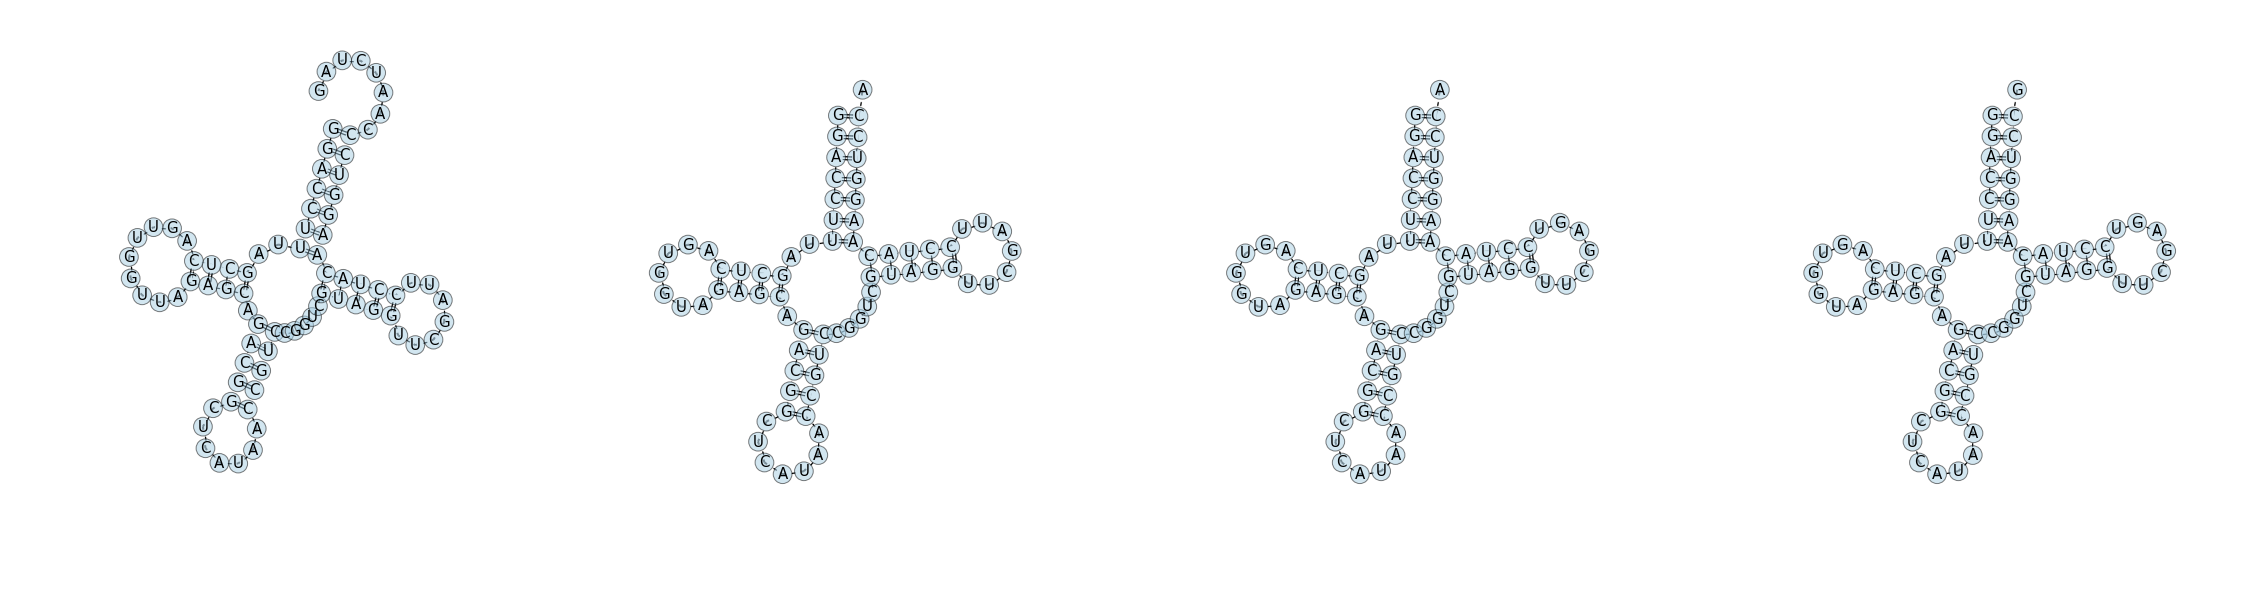

CPU times: user 4.99 s, sys: 372 ms, total: 5.36 s
Wall time: 11.7 s


In [13]:
%%time
import graphlearn.utils.draw as draw
import itertools

#parameters
sequences = get_sequences(withoutnames=True)
id_start=66
id_end=id_start+3
sequences = sequences[id_start:id_end]
n_steps=20
# sample
graphs = sampler.sample(sequences,
                        n_samples=4,
                        batch_size=1,
                        n_steps=n_steps,
                        n_jobs=NJOBS,
                        quick_skip_orig_cip=True,
                        probabilistic_core_choice=True,
                        burnin=0,
                        improving_threshold=0.9,
                        improving_linear_start=0.1,
                        max_size_diff=20,
                        select_cip_max_tries=40,
                        keep_duplicates=False,
                        accept_min_similarity=0.55,
                        include_seed=True,
                        backtrack=10,
                        monitor=True)



# collect data and print graph samples
scores=[]
sequences=[]
ids=range(id_start,id_end)
for i,path_graphs in enumerate(graphs):
    print 'Graph id: %d'%(ids[i])
    scores.append(sampler.monitors[i].sampling_info['score_history'])
    #path_graphs = graph
    sequences.append(sampler.monitors[i].sampling_info['notes'])    
    draw.graphlearn(path_graphs,contract=True,
                           n_graphs_per_line=5, size=10, 
                           colormap='Paired', invert_colormap=False,node_border=0.5, vertex_color='color_level',
                           vertex_alpha=0.5, edge_alpha=0.7, node_size=350,edge_label='label',layout="RNA"
                          )

## show score history and compare to covariance model score

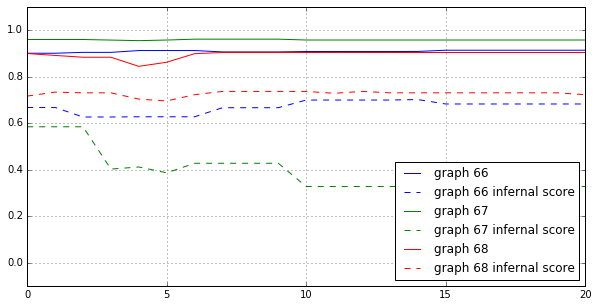

In [14]:
colors=['b','g','r','c','m','y','k','w']
'''
plot scores
'''
%matplotlib inline
from itertools import islice
import matplotlib.pyplot as plt
import numpy as np
step=1
num_graphs_per_plot=3
num_plots=np.ceil([len(scores)/num_graphs_per_plot])
for i in range(num_plots):
    plt.figure(figsize=(10,5))
    for j,score in enumerate(scores[i*num_graphs_per_plot:i*num_graphs_per_plot+num_graphs_per_plot]):
        data = list(islice(score,None, None, step))
        plt.plot(data,ls='-',color=colors[j], label='graph %d'%(j+i*num_graphs_per_plot+id_start))
        
        # okok now we need to add the infernal evaluation
        seqs=sequences[i*num_graphs_per_plot+j]
        seqs=seqs.split('n')
        data2= infernal.infernal_checker(seqs,cmfile='../rf00005.cm')
        #draw line
        plt.plot(data2,ls='--',color=colors[j], label='graph %d infernal score'%(j+i*num_graphs_per_plot+id_start))
    
    plt.legend(loc='lower right')
    plt.grid()
    plt.ylim(-0.1,1.1)
    plt.show()